In [1]:
import os
import math
import dill
from itertools import permutations

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib import gridspec
from sklearn.linear_model import HuberRegressor as hubreg
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from pingouin import mixed_anova, anova, pairwise_tukey


import suite2p as s2p

import TwoPUtils as tpu
import STX3KO_analyses as stx
from STX3KO_analyses import utilities as u

ko_mice = stx.ymaze_sess_deets.ko_mice
ctrl_mice = stx.ymaze_sess_deets.ctrl_mice


%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
figdir = "/mnt/BigDisk/YMazeResults/neural"

In [3]:
1./30

0.03333333333333333

In [32]:


def lap_stats(sess, fam = True, placecells = True):
    
    if fam:
        cellmask, _ = place_cell_masks(sess)
        trialmask = sess.trial_info['LR']==-1*sess.novel_arm
        
    else:
        _,cellmask = place_cell_masks(sess)
        trialmask = sess.trial_info['LR']==sess.novel_arm
        
    if not placecells:
        cellmask = np.zeros(cellmask.shape)<1
        
    trial_mat = sess.trial_matrices['spks'][:,:,cellmask]
    trial_mat = trial_mat[trialmask,:,:]
    trial_mat[np.isnan(trial_mat)]=1E-5
    avg_trial_mat = trial_mat.mean(axis=0,keepdims=True)

    
    
    maxnorm = trial_mat.mean(axis=0)
    _max, _min = np.amax(maxnorm,axis=0,keepdims=True), np.amin(maxnorm,axis=0,keepdims=True)
    maxnorm = (maxnorm-_min)/(_max-_min +1E-5)
    maxinds = np.argmax(maxnorm,axis=0)

    half_mask = maxnorm<=.5
    fw = []
    lw, rw = [], []
    for cell in range(maxnorm.shape[1]):
        l = np.argwhere(half_mask[:maxinds[cell],cell])
        r = np.argwhere(half_mask[maxinds[cell]:,cell])
        if l.shape[0]>0 and r.shape[0]>0:  
            ledge, redge = l[-1][0], r[0][0]+ maxinds[cell]
            fw.append(redge-ledge)
            lw.append(maxinds[cell]-ledge)
            rw.append(redge-maxinds[cell])

    trial_mat = sp.ndimage.filters.gaussian_filter1d(trial_mat,3,axis=0)
    trial_mat_norm = trial_mat/(np.nansum(trial_mat, axis=1,keepdims=True)+1E-5)
    
    avg_trial_mat_norm = avg_trial_mat/(avg_trial_mat.sum(axis=1,keepdims=True)+1E-5)
    
    
#     mask = avg_trial_mat_norm<.033
    tmp_mat = np.copy(avg_trial_mat)
    tmp_mat /= tmp_mat.mean(axis=1)
    max_counts = []
    for cell in range(tmp_mat.shape[-1]):
        extm,_ = sp.signal.find_peaks(tmp_mat[0,:,cell],height=1)
        max_counts.append(extm.shape[0])
    max_counts = np.array(max_counts)
        
#     tmp_mat[mask]=.033
#     extm = sp.signal.argrelmax(tmp_mat,axis=1)[2]
# #     extm,_ = sp.signal.find_peaks(tmp_mat,height=1,axis=1)[2]
#     max_counts = np.bincount(extm)

    inds = np.arange(0,trial_mat.shape[1])[np.newaxis, :, np.newaxis]
    
    com = (trial_mat_norm*inds).sum(axis=1,keepdims=True)
    std = np.power((np.power(inds - com,2)*trial_mat_norm).sum(axis=1,keepdims=True),.5)
    
    skewness = (np.power((inds-com)/(std+1E-5),3)*trial_mat_norm).sum(axis=1)
    kurtosis = (np.power((inds-com)/(std+1E-5),4)*trial_mat_norm).sum(axis=1)
    

    avg_com = (avg_trial_mat_norm*inds).sum(axis=1,keepdims=True)
    avg_std = np.power((np.power(inds - avg_com,2)*avg_trial_mat_norm).sum(axis=1,keepdims=True),.5)

    avg_skewness = (np.power((inds-avg_com)/(avg_std+1E-5),3)*avg_trial_mat_norm).sum(axis=1)
    avg_kurtosis = (np.power((inds-avg_com)/(avg_std+1E-5),4)*avg_trial_mat_norm).sum(axis=1)
    
    return {'com': com, 
            'std': std, 
            'skewness': skewness,
            'kurtosis': kurtosis,
            'avg_com': avg_com.ravel(), 
            'avg_std': avg_std.ravel(), 
            'avg_skewness': avg_skewness.ravel(),
            'avg_kurtosis': avg_kurtosis.ravel(),
            'avg_entropy': sp.stats.entropy(avg_trial_mat[0,:,:],axis=0),
            'max_counts': max_counts,
            'field_width': np.array(fw),
            'left_width': np.array(lw),
            'right_width': np.array(rw),
            'field_asymmetry': np.array(lw ) - np.array(rw)}

def avg_stats_violinplots(ko_dict, ctrl_dict, data_key, scatter_only = False):
    fig,ax = plt.subplots(figsize= [15,5])
    
    n_days = len(ko_dict[ko_mice[0]])
    ko_means = np.zeros([n_days,len(ko_mice)])
    for k, (mouse, data_list) in enumerate(ko_dict.items()):
        for day, data_dict in enumerate(data_list):
            data = data_dict[data_key]
            
        
            ko_means[day,k]=data.mean()
            if not scatter_only:
                parts = ax.violinplot(data,positions=[2*day+.1*k],showextrema=False,showmeans=False,widths = .1, points= 10)
                for pc in parts['bodies']:
                    pc.set_facecolor('red')
                    pc.set_edgecolor('black')
                    pc.set_alpha(.5)
            _ = ax.scatter(2*day + .1*k, data.mean(),color='red')
            
                

    ctrl_means = np.zeros([n_days,len(ctrl_mice)])
    for k, (mouse, data_list) in enumerate(ctrl_dict.items()):
        for day, data_dict in enumerate(data_list):
            data = data_dict[data_key]
            
            ctrl_means[day,k] = data.mean()
            if not scatter_only:
                parts = ax.violinplot(data,positions=[2*day + .6+.1*k],showextrema=False,showmeans=False,widths = .1, points= 10)
                for pc in parts['bodies']:
                    pc.set_facecolor('black')
                    pc.set_edgecolor('black')
                    pc.set_alpha(.5)
            _ = ax.scatter(2*day + .6+ .1*k, data.mean(),color='black')
    
            

        
    
        
    t,p = sp.stats.ttest_ind(ko_means,ctrl_means,axis=1)
    print(t,p)
    
    p = [sp.stats.ranksums(ko_means[i,:],ctrl_means[i,:])[1] for i in range(5)]
    print(p)
    return (fig, ax), ko_means, ctrl_means, (t,p)


In [33]:
single_mouse_lap_stats = lambda mouse, days, fam: [lap_stats(u.load_single_day(mouse,day=day), placecells=True, fam=fam) for day in days] 

ko_fam_lap_stats = {mouse: single_mouse_lap_stats(mouse, range(6),True) for mouse in ko_mice}
ctrl_fam_lap_stats = {mouse: single_mouse_lap_stats(mouse, range(6), True) for mouse in ctrl_mice}

ko_nov_lap_stats = {mouse: single_mouse_lap_stats(mouse, range(6), False) for mouse in ko_mice}
ctrl_nov_lap_stats = {mouse: single_mouse_lap_stats(mouse, range(6), False) for mouse in ctrl_mice}

{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 6, 'scan': 14, 'novel': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus2/2P_Data/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus2/2P_Data/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel': -1, 'ravel_ind': 2}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel': -1, 'ravel_ind': 3}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel': -1, 'ravel_ind': 4}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel': -1, 'ravel_ind': 5}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel': -1, 'ravel_ind': 6}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel': 1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel': 1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel': 1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel': 1, 'ravel_ind': 3}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9, 'novel': 1, '

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 6, 'scan': 14, 'novel': -1, 'ravel_ind': 1}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel': -1, 'ravel_ind': 2}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel': -1, 'ravel_ind': 3}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel': -1, 'ravel_ind': 4}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel': -1, 'ravel_ind': 5}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel': -1, 'ravel_ind': 6}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel': 1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel': 1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel': 1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel': 1,

[-3.28806382 -3.0725073  -6.31492703 -5.38382643 -5.58701462 -4.2698013 ] [0.01105393 0.01528965 0.00022908 0.00065862 0.00051804 0.00272491]
[0.009023438818080326, 0.028280122568276955, 0.009023438818080326, 0.009023438818080326, 0.009023438818080326]
[[5.79339853 5.90825688 5.06060606 5.4519573  4.99816345]
 [5.46244131 5.86461538 4.9291866  5.24192059 4.95066414]
 [5.11382114 5.25082508 5.10414747 5.33496094 4.6631016 ]
 [5.43776824 5.24414716 4.8198567  5.53358209 4.53581662]
 [5.30277186 5.32160804 5.04069176 5.3637227  4.65856481]
 [5.61172742 5.27586207 5.1022409  5.78881279 4.91989199]] [[6.06293706 5.98427261 6.94490644 6.01005025 6.61618062]
 [6.36770428 5.96210873 6.13218971 5.4223301  6.47983015]
 [5.92266187 5.95683453 6.06687403 5.75159817 6.24414716]
 [6.12518195 6.35021708 5.95427729 6.33667883 6.31280193]
 [6.27095517 5.94314869 5.87866109 6.03610503 6.52168675]
 [6.2117061  6.3752809  6.18618042 5.81688708 6.70350404]]


Text(0.5, 0, 'Day')

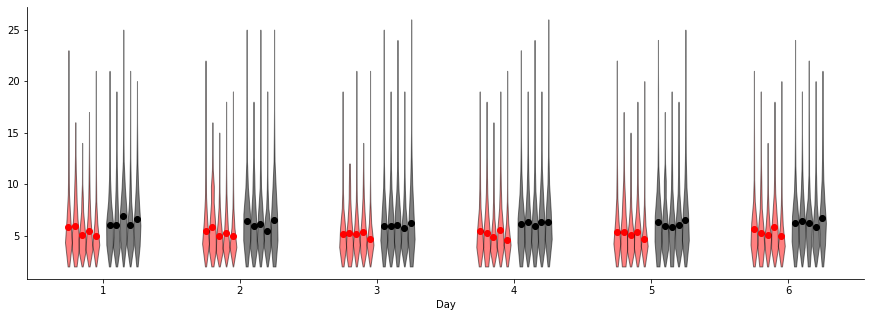

In [6]:
(fig, ax), ko_means, ctrl_means, (t,p) = avg_stats_violinplots(ko_fam_lap_stats,ctrl_fam_lap_stats,'field_width')
print(ko_means,ctrl_means)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.set_ylabel('Spatial Standard Deviation')
ax.set_xticks([.5, 2.5, 4.5, 6.5, 8.5, 10.5])
ax.set_xticklabels([1, 2, 3, 4, 5, 6])
ax.set_xlabel('Day')
# fig.savefig(os.path.join(figdir,"fam_avg_std.pdf"))

In [116]:
df = {'ko_ctrl':[],
     'day':[],
     'std':[],
     'mouse':[]}

for mouse in range(5): 
    for day in range(6):
        
        df['ko_ctrl'].append(0)
        df['day'].append(day)
        df['std'].append(ko_means[day,mouse])
        df['mouse'].append(mouse)
        
for mouse in range(5): 
    for day in range(6):
        
        df['ko_ctrl'].append(1)
        df['day'].append(day)
        df['std'].append(ctrl_means[day,mouse])
        df['mouse'].append(mouse+5)
        
df = pd.DataFrame(df)
aov = mixed_anova(data=df,dv='std',between='ko_ctrl', within='day',subject='mouse')
print(aov)


print('Tukey test on groups')
stats = pairwise_tukey(data= df, dv='std', between = 'ko_ctrl')
print(stats)

print('Tukey on each day')
for day in range(6):
    stats = pairwise_tukey(data= df[df['day']==day], dv='std', between = 'ko_ctrl')
    print(stats)
    
print('Tukey on days')
stats = pairwise_tukey(data= df, dv='std', between = 'day')
print(stats)

        Source         SS  DF1  DF2         MS          F     p-unc       np2  \
0      ko_ctrl  12.686251    1    8  12.686251  27.668938  0.000764  0.775715   
1          day   1.266388    5   40   0.253278   7.249027  0.000065  0.475376   
2  Interaction   0.085262    5   40   0.017052   0.488055  0.783125  0.057499   

        eps  
0       NaN  
1  0.628739  
2       NaN  
Tukey test on groups
   A  B   mean(A)   mean(B)      diff        se          T  p-tukey    hedges
0  0  1  6.526046  7.445692 -0.919647  0.085884 -10.707952    0.001 -2.728875
Tukey on each day
   A  B  mean(A)   mean(B)     diff        se         T   p-tukey    hedges
0  0  1  6.83596  7.737841 -0.90188  0.238591 -3.780019  0.005388 -2.159337
   A  B   mean(A)   mean(B)      diff        se         T   p-tukey    hedges
0  0  1  6.500704  7.312441 -0.811737  0.238496 -3.403563  0.009312 -1.944286
   A  B   mean(A)   mean(B)      diff        se         T   p-tukey    hedges
0  0  1  6.385777  7.277373 -0.891597 

[2.36690694 2.31019022 3.46253053 3.28968704 2.74086353 3.27784003] [0.04546539 0.04967433 0.00853596 0.01102719 0.02541528 0.01122396]
[0.04720176769014221, 0.04720176769014221, 0.016293603621028527, 0.009023438818080326, 0.016293603621028527]
[[8.39511678 8.308365   8.20897558 8.09453635 8.28057269]
 [8.31260537 8.23850607 8.09198784 7.89206047 8.19175209]
 [8.14889709 7.98427491 8.04142052 7.89673007 8.10450162]
 [8.00547926 8.23739035 8.03285125 7.96965832 8.1341452 ]
 [8.05278157 8.0154982  8.065629   7.94933575 8.04615883]
 [8.15406986 7.96495996 7.81210731 7.97863582 8.05158069]] [[7.9439493  8.11746546 8.19518136 7.7799587  8.1557811 ]
 [7.47119919 8.00263373 8.07624071 7.57285175 7.9574523 ]
 [7.56438662 7.59341836 7.88030891 7.78314373 7.90444004]
 [7.72551638 7.90903768 7.95782518 7.87433059 7.88591015]
 [7.65398712 7.87600707 8.01291873 7.74597754 7.92150101]
 [7.55018656 7.42063274 7.73345979 7.7732631  7.86938067]]


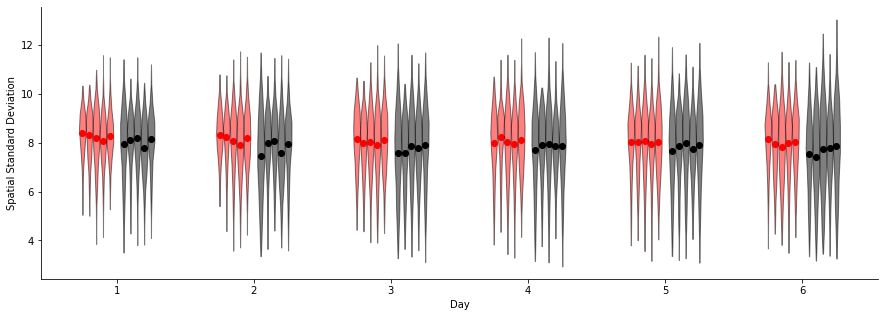

In [117]:
(fig, ax), ko_means, ctrl_means, (t,p) = avg_stats_violinplots(ko_fam_lap_stats,ctrl_fam_lap_stats,'avg_std')
print(ko_means,ctrl_means)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Spatial Standard Deviation')
ax.set_xticks([.5, 2.5, 4.5, 6.5, 8.5, 10.5])
ax.set_xticklabels([1, 2, 3, 4, 5, 6])
ax.set_xlabel('Day')
fig.savefig(os.path.join(figdir,"fam_avg_std.pdf"))

In [118]:
df = {'ko_ctrl':[],
     'day':[],
     'std':[],
     'mouse':[]}

for mouse in range(5): 
    for day in range(6):
        
        df['ko_ctrl'].append(0)
        df['day'].append(day)
        df['std'].append(ko_means[day,mouse])
        df['mouse'].append(mouse)
        
for mouse in range(5): 
    for day in range(6):
        
        df['ko_ctrl'].append(1)
        df['day'].append(day)
        df['std'].append(ctrl_means[day,mouse])
        df['mouse'].append(mouse+5)
        
df = pd.DataFrame(df)
aov = mixed_anova(data=df,dv='std',between='ko_ctrl', within='day',subject='mouse')
print(aov)


print('Tukey test on groups')
stats = pairwise_tukey(data= df, dv='std', between = 'ko_ctrl')
print(stats)

print('Tukey on each day')
for day in range(6):
    stats = pairwise_tukey(data= df[df['day']==day], dv='std', between = 'ko_ctrl')
    print(stats)
    
print('Tukey on days')
stats = pairwise_tukey(data= df, dv='std', between = 'day')
print(stats)

        Source        SS  DF1  DF2        MS          F     p-unc       np2  \
0      ko_ctrl  1.001620    1    8  1.001620  13.047642  0.006860  0.619910   
1          day  0.581843    5   40  0.116369   9.992439  0.000003  0.555369   
2  Interaction  0.050277    5   40  0.010055   0.863453  0.514003  0.097417   

        eps  
0       NaN  
1  0.489143  
2       NaN  
Tukey test on groups
   A  B   mean(A)   mean(B)      diff        se         T  p-tukey    hedges
0  0  1  8.088686  7.830278  0.258408  0.044361  5.825104    0.001  1.484503
Tukey on each day
   A  B   mean(A)   mean(B)      diff        se         T   p-tukey    hedges
0  0  1  8.257513  8.038467  0.219046  0.092545  2.366907  0.045466  1.352096
   A  B   mean(A)   mean(B)      diff        se        T   p-tukey    hedges
0  0  1  8.145382  7.816076  0.329307  0.142545  2.31019  0.049674  1.319697
   A  B   mean(A)  mean(B)      diff        se         T   p-tukey    hedges
0  0  1  8.035165  7.74514  0.290025  0.083761 

[3.17937048 3.10271336 3.83524869 3.08811177 3.20315756 3.50637125] [0.0130098  0.01460565 0.00498066 0.01493221 0.01255265 0.00800401]
[0.016293603621028527, 0.028280122568276955, 0.009023438818080326, 0.028280122568276955, 0.016293603621028527]
[[8.33339557 7.9494068  7.6431719  7.85943023 8.0326604 ]
 [7.99894711 7.79768679 7.57788137 7.50210693 7.95526496]
 [7.78627104 7.81043726 7.63087429 7.64147968 8.05906028]
 [7.66379964 7.84822523 7.61038121 7.71778203 8.00022951]
 [7.7018013  7.85082992 7.63364163 7.60863274 7.87837177]
 [8.15646875 8.2028874  7.67140544 7.98553173 8.30527423]] [[7.12900266 7.63299811 7.36617043 7.59743451 7.66965178]
 [7.09663061 7.5094366  7.53153492 7.40491869 7.32971596]
 [7.09779387 7.5330335  7.45223126 7.45675913 7.24455193]
 [7.11285982 7.16264325 7.2547867  7.58949357 7.66411446]
 [7.04663142 7.54917148 7.32477105 7.19092479 7.62258152]
 [7.47114599 7.09613836 7.52379213 7.77662964 7.65264382]]


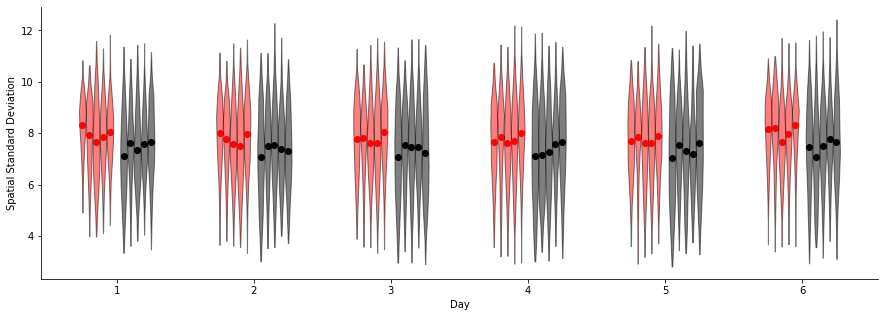

In [119]:
(fig, ax), ko_means, ctrl_means, (t,p) = avg_stats_violinplots(ko_nov_lap_stats,ctrl_nov_lap_stats,'avg_std')
print(ko_means,ctrl_means)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Spatial Standard Deviation')
ax.set_xticks([.5, 2.5, 4.5, 6.5, 8.5, 10.5])
ax.set_xticklabels([1, 2, 3, 4, 5, 6])
ax.set_xlabel('Day')
fig.savefig(os.path.join(figdir,"nov_avg_std.pdf"))

In [120]:
df = {'ko_ctrl':[],
     'day':[],
     'std':[],
     'mouse':[]}

for mouse in range(5): 
    for day in range(6):
        
        df['ko_ctrl'].append(0)
        df['day'].append(day)
        df['std'].append(ko_means[day,mouse])
        df['mouse'].append(mouse)
        
for mouse in range(5): 
    for day in range(6):
        
        df['ko_ctrl'].append(1)
        df['day'].append(day)
        df['std'].append(ctrl_means[day,mouse])
        df['mouse'].append(mouse+5)
        
df = pd.DataFrame(df)
aov = mixed_anova(data=df,dv='std',between='ko_ctrl', within='day',subject='mouse')
print(aov)


print('Tukey test on groups')
stats = pairwise_tukey(data= df, dv='std', between = 'ko_ctrl')
print(stats)

print('Tukey on each day')
for day in range(6):
    stats = pairwise_tukey(data= df[df['day']==day], dv='std', between = 'ko_ctrl')
    print(stats)
    
print('Tukey on days')
stats = pairwise_tukey(data= df, dv='std', between = 'day')
print(stats)

        Source        SS  DF1  DF2        MS          F     p-unc       np2  \
0      ko_ctrl  2.958437    1    8  2.958437  19.769099  0.002150  0.711910   
1          day  0.515061    5   40  0.103012   4.141084  0.003996  0.341080   
2  Interaction  0.055811    5   40  0.011162   0.448723  0.811643  0.053111   

        eps  
0       NaN  
1  0.561103  
2       NaN  
Tukey test on groups
   A  B   mean(A)   mean(B)      diff        se        T  p-tukey    hedges
0  0  1  7.847111  7.403006  0.444105  0.056356  7.88038    0.001  2.008281
Tukey on each day
   A  B   mean(A)   mean(B)      diff        se        T   p-tukey    hedges
0  0  1  7.963613  7.479051  0.484561  0.152408  3.17937  0.013009  1.816216
   A  B   mean(A)   mean(B)     diff        se         T   p-tukey    hedges
0  0  1  7.766377  7.374447  0.39193  0.126318  3.102713  0.014605  1.772425
   A  B   mean(A)   mean(B)      diff        se         T   p-tukey    hedges
0  0  1  7.785625  7.356874  0.428751  0.111792  3

[1.05976762 1.71748029 1.38476316 1.49395156 0.40481796 0.89628598] [0.32019538 0.12421937 0.2035177  0.17354295 0.69621962 0.39626844]
[0.25059205068568424, 0.17452534056858338, 0.25059205068568424, 0.25059205068568424, 0.9168149485280885]
[[ 0.01608358  0.04132833 -0.09714543 -0.03147691  0.05529347]
 [ 0.00057281  0.0288789  -0.03883074 -0.06995473  0.04765752]
 [-0.04728777  0.02325574 -0.06362405 -0.09445695  0.07274438]
 [-0.09716062  0.04201205 -0.06076755 -0.06139254  0.057953  ]
 [-0.12072234  0.073104   -0.06238755 -0.06989682  0.06953451]
 [-0.01927241 -0.03266066 -0.06204834 -0.02211946  0.08067409]] [[-0.09865545 -0.0117024  -0.06408574  0.0104529  -0.03100864]
 [-0.17421957 -0.04060861 -0.03338367 -0.0245608  -0.05937983]
 [-0.13552207 -0.01364545 -0.07058541 -0.04448554 -0.10334807]
 [-0.09570066 -0.02250918 -0.10324375 -0.04448672 -0.12599534]
 [-0.0546381   0.024714   -0.04860866 -0.0026899  -0.12411983]
 [-0.09999131  0.04352671 -0.03703502 -0.03209094 -0.08654231]]


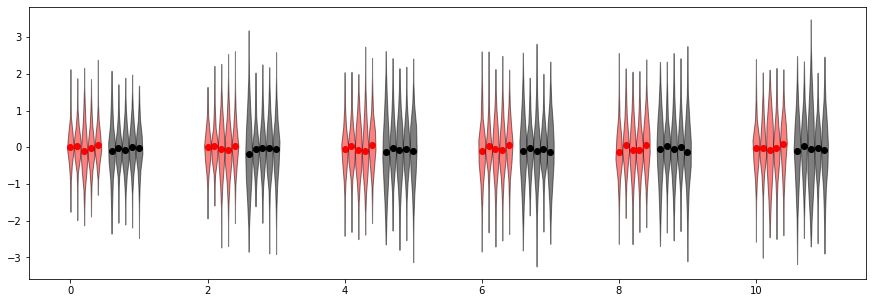

In [121]:
(fig, ax), ko_means, ctrl_means, (t,p) = avg_stats_violinplots(ko_fam_lap_stats,ctrl_fam_lap_stats,'avg_skewness')
print(ko_means,ctrl_means)

In [122]:
df = {'ko_ctrl':[],
     'day':[],
     'std':[],
     'mouse':[]}

for mouse in range(5): 
    for day in range(6):
        
        df['ko_ctrl'].append(0)
        df['day'].append(day)
        df['std'].append(ko_means[day,mouse])
        df['mouse'].append(mouse)
        
for mouse in range(5): 
    for day in range(6):
        
        df['ko_ctrl'].append(1)
        df['day'].append(day)
        df['std'].append(ctrl_means[day,mouse])
        df['mouse'].append(mouse+5)
        
df = pd.DataFrame(df)
aov = mixed_anova(data=df,dv='std',between='ko_ctrl', within='day',subject='mouse')
print(aov)


print('Tukey test on groups')
stats = pairwise_tukey(data= df, dv='std', between = 'ko_ctrl')
print(stats)


        Source        SS  DF1  DF2        MS         F     p-unc       np2  \
0      ko_ctrl  0.026546    1    8  0.026546  1.671661  0.232123  0.172841   
1          day  0.006928    5   40  0.001386  1.282138  0.290671  0.138130   
2  Interaction  0.003145    5   40  0.000629  0.582069  0.713460  0.067824   

        eps  
0       NaN  
1  0.493944  
2       NaN  
Tukey test on groups
   A  B   mean(A)   mean(B)      diff        se         T   p-tukey    hedges
0  0  1 -0.014737 -0.056805  0.042068  0.014398  2.921878  0.004952  0.744628


[2.23161237 1.72323551 2.18028281 1.11147437 1.63006452 3.99909831] [0.05615555 0.1231397  0.06083563 0.2986484  0.14173518 0.00395475]
[0.04720176769014221, 0.11718508719813801, 0.07580017458236125, 0.25059205068568424, 0.25059205068568424]
[[-0.00378908  0.21095973  0.03342026 -0.03502077  0.00100288]
 [-0.01968391  0.25907984 -0.0366362  -0.06939745  0.00080806]
 [-0.04806053  0.20820203 -0.01462324 -0.07050124  0.12142093]
 [-0.15389881  0.26661909 -0.06424921 -0.080716    0.11567667]
 [-0.09615497  0.23278614 -0.04744629 -0.08076745  0.17842988]
 [-0.012368    0.03306763 -0.048306   -0.02072171  0.05273196]] [[-0.08884499 -0.10251904 -0.11676475 -0.0804004   0.02811675]
 [-0.06506633 -0.14513004 -0.01922894 -0.13300086 -0.05396224]
 [-0.03987285 -0.17522231 -0.03090472 -0.11970973 -0.09198372]
 [-0.06743934 -0.18318378 -0.10421446  0.05660701 -0.09591869]
 [-0.08636485 -0.0457949  -0.02228196 -0.13702388 -0.11530686]
 [-0.10486471 -0.11606446 -0.07270541 -0.05974288 -0.07007303]]


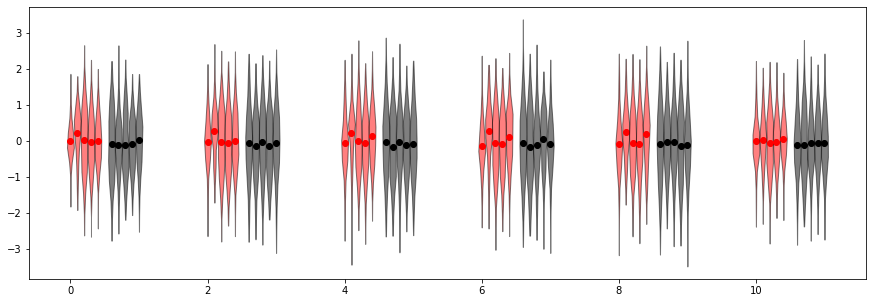

In [123]:
(fig, ax), ko_means, ctrl_means, (t,p) = avg_stats_violinplots(ko_nov_lap_stats,ctrl_nov_lap_stats,'avg_skewness')
print(ko_means,ctrl_means)

In [124]:
df = {'ko_ctrl':[],
     'day':[],
     'std':[],
     'mouse':[]}

for mouse in range(5): 
    for day in range(6):
        
        df['ko_ctrl'].append(0)
        df['day'].append(day)
        df['std'].append(ko_means[day,mouse])
        df['mouse'].append(mouse)
        
for mouse in range(5): 
    for day in range(6):
        
        df['ko_ctrl'].append(1)
        df['day'].append(day)
        df['std'].append(ctrl_means[day,mouse])
        df['mouse'].append(mouse+5)
        
df = pd.DataFrame(df)
aov = mixed_anova(data=df,dv='std',between='ko_ctrl', within='day',subject='mouse')
print(aov)


print('Tukey test on groups')
stats = pairwise_tukey(data= df, dv='std', between = 'ko_ctrl')
print(stats)


        Source        SS  DF1  DF2        MS         F     p-unc       np2  \
0      ko_ctrl  0.178295    1    8  0.178295  4.438452  0.068216  0.356833   
1          day  0.003998    5   40  0.000800  0.217712  0.952890  0.026493   
2  Interaction  0.003306    5   40  0.000661  0.180018  0.968537  0.022007   

       eps  
0      NaN  
1  0.68294  
2      NaN  
Tukey test on groups
   A  B   mean(A)   mean(B)      diff       se         T  p-tukey    hedges
0  0  1  0.027062 -0.081962  0.109024  0.02338  4.663119    0.001  1.188376


[2.11734864 2.01476481 2.61697446 1.691091   2.19396904 2.76777201] [0.06710153 0.07869479 0.03079484 0.1292836  0.05955132 0.0243804 ]
[0.07580017458236125, 0.07580017458236125, 0.028280122568276955, 0.17452534056858338, 0.07580017458236125]


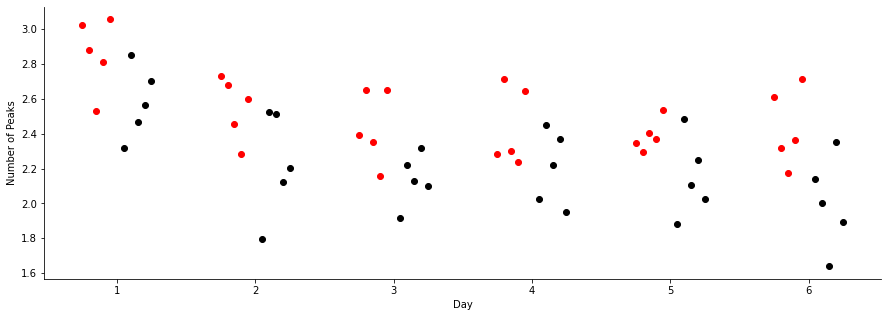

In [34]:
(fig, ax), ko_means, ctrl_means, (t,p) = avg_stats_violinplots(ko_fam_lap_stats,ctrl_fam_lap_stats,'max_counts', scatter_only=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Number of Peaks')
ax.set_xticks([.5, 2.5, 4.5, 6.5, 8.5, 10.5])
ax.set_xticklabels([1, 2, 3, 4, 5, 6])
ax.set_xlabel('Day')
fig.savefig(os.path.join(figdir,"fam_max_counts.pdf"))

In [35]:
df = {'ko_ctrl':[],
     'day':[],
     'std':[],
     'mouse':[]}

for mouse in range(5): 
    for day in range(6):
        
        df['ko_ctrl'].append(0)
        df['day'].append(day)
        df['std'].append(ko_means[day,mouse])
        df['mouse'].append(mouse)
        
for mouse in range(5): 
    for day in range(6):
        
        df['ko_ctrl'].append(1)
        df['day'].append(day)
        df['std'].append(ctrl_means[day,mouse])
        df['mouse'].append(mouse+5)
        
df = pd.DataFrame(df)
aov = mixed_anova(data=df,dv='std',between='ko_ctrl', within='day',subject='mouse')
print(aov)


print('Tukey test on groups')
stats = pairwise_tukey(data= df, dv='std', between = 'ko_ctrl')
print(stats)


        Source        SS  DF1  DF2        MS          F         p-unc  \
0      ko_ctrl  1.361314    1    8  1.361314   9.714457  1.429764e-02   
1          day  1.650106    5   40  0.330021  11.946566  4.153514e-07   
2  Interaction  0.063289    5   40  0.012658   0.458204  8.048276e-01   

        np2       eps  
0  0.548391       NaN  
1  0.598928  0.517479  
2  0.054173       NaN  
Tukey test on groups
   A  B   mean(A)  mean(B)      diff        se         T  p-tukey    hedges
0  0  1  2.519495  2.21824  0.301255  0.067291  4.476881    0.001  1.140914


[1.77285067 1.45672209 2.19470929 1.60033582 1.59805863 3.45381342] [0.11418881 0.18329305 0.05948262 0.14819166 0.14869713 0.00864613]
[0.11718508719813801, 0.34720763934942456, 0.04720176769014221, 0.17452534056858338, 0.17452534056858338]


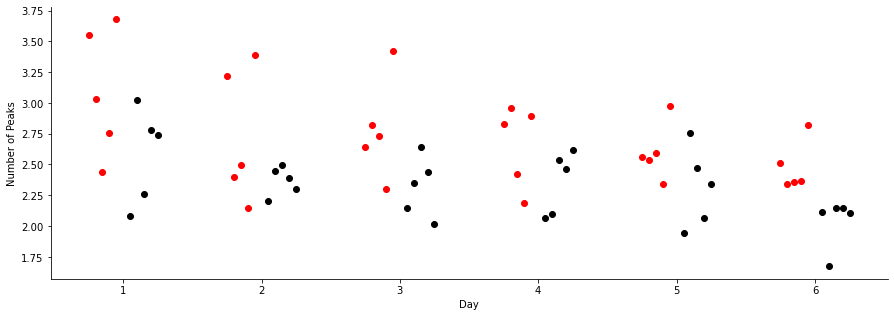

In [36]:
(fig, ax), ko_means, ctrl_means, (t,p) = avg_stats_violinplots(ko_nov_lap_stats,ctrl_nov_lap_stats,'max_counts', scatter_only=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Number of Peaks')
ax.set_xticks([.5, 2.5, 4.5, 6.5, 8.5, 10.5])
ax.set_xticklabels([1, 2, 3, 4, 5, 6])
ax.set_xlabel('Day')
fig.savefig(os.path.join(figdir,"nov_max_counts.pdf"))

In [37]:
df = {'ko_ctrl':[],
     'day':[],
     'std':[],
     'mouse':[]}

for mouse in range(5): 
    for day in range(6):
        
        df['ko_ctrl'].append(0)
        df['day'].append(day)
        df['std'].append(ko_means[day,mouse])
        df['mouse'].append(mouse)
        
for mouse in range(5): 
    for day in range(6):
        
        df['ko_ctrl'].append(1)
        df['day'].append(day)
        df['std'].append(ctrl_means[day,mouse])
        df['mouse'].append(mouse+5)
        
df = pd.DataFrame(df)
aov = mixed_anova(data=df,dv='std',between='ko_ctrl', within='day',subject='mouse')
print(aov)


print('Tukey test on groups')
stats = pairwise_tukey(data= df, dv='std', between = 'ko_ctrl')
print(stats)


        Source        SS  DF1  DF2        MS         F     p-unc       np2  \
0      ko_ctrl  2.347098    1    8  2.347098  6.155093  0.038055  0.434832   
1          day  1.728518    5   40  0.345704  5.625733  0.000512  0.412876   
2  Interaction  0.110996    5   40  0.022199  0.361253  0.871902  0.043206   

        eps  
0       NaN  
1  0.723608  
2       NaN  
Tukey test on groups
   A  B   mean(A)   mean(B)      diff        se         T  p-tukey    hedges
0  0  1  2.724755  2.329188  0.395567  0.091903  4.304185    0.001  1.096903


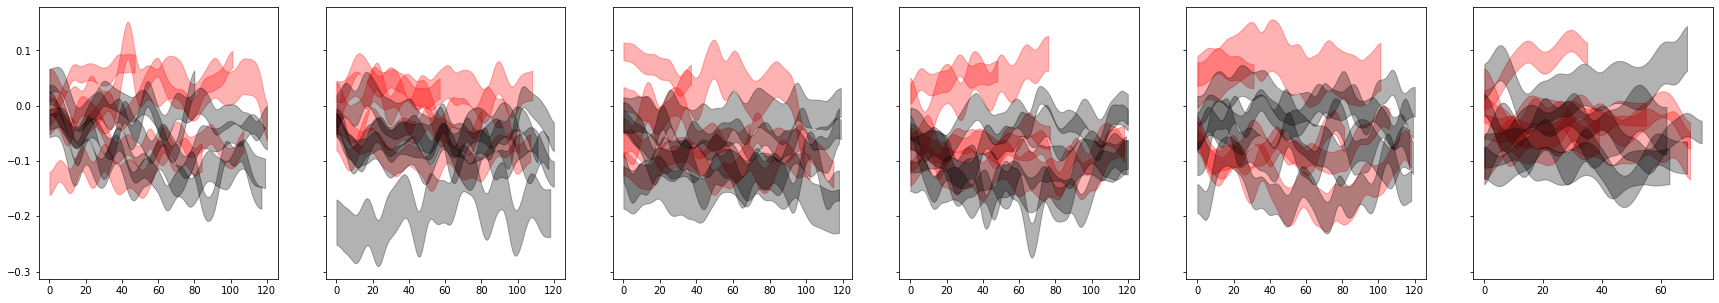

In [13]:
fig,ax = plt.subplots(1,6, figsize = [30,5],sharey=True)
key = 'skewness'
for mouse in ko_mice:
    for day in range(6):
        std = np.squeeze(ko_fam_lap_stats[mouse][day][key])

        mu, sem  = std.mean(axis=-1), sp.stats.sem(std,axis=-1)
        x = np.arange(0,mu.shape[0])

        ax[day].fill_between(x,mu-sem,mu+sem, color='red',alpha = .3)

for mouse in ctrl_mice:
    for day in range(6):
        std = np.squeeze(ctrl_fam_lap_stats[mouse][day][key])

        mu, sem  = std.mean(axis=-1), sp.stats.sem(std,axis=-1)
        x = np.arange(0,mu.shape[0])

        ax[day].fill_between(x,mu-sem,mu+sem, color='black',alpha = .3)

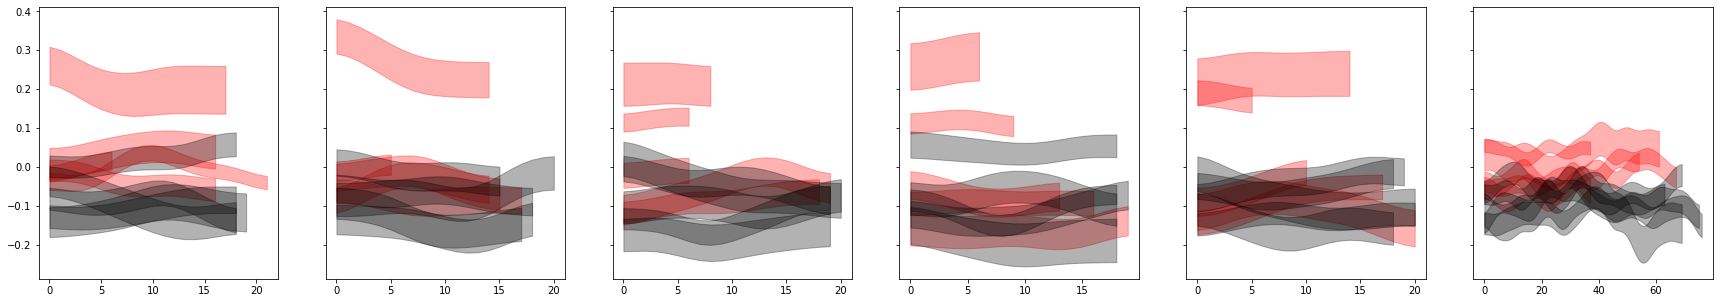

In [14]:
fig,ax = plt.subplots(1,6, figsize = [30,5],sharey=True)
key = 'skewness'
for mouse in ko_mice:
    for day in range(6):
        std = np.squeeze(ko_nov_lap_stats[mouse][day][key])

        mu, sem  = std.mean(axis=-1), sp.stats.sem(std,axis=-1)
        x = np.arange(0,mu.shape[0])

        ax[day].fill_between(x,mu-sem,mu+sem, color='red',alpha = .3)

for mouse in ctrl_mice:
    for day in range(6):
        std = np.squeeze(ctrl_nov_lap_stats[mouse][day][key])

        mu, sem  = std.mean(axis=-1), sp.stats.sem(std,axis=-1)
        x = np.arange(0,mu.shape[0])

        ax[day].fill_between(x,mu-sem,mu+sem, color='black',alpha = .3)

(3375,)
(3273,)
(3656,)
(3162,)
(2851,)
(4715,)
(3202,)
(3214,)
(3361,)
(3780,)
(3703,)
(4735,)


Text(0.5, 0, 'Spatial Standard Deviation')

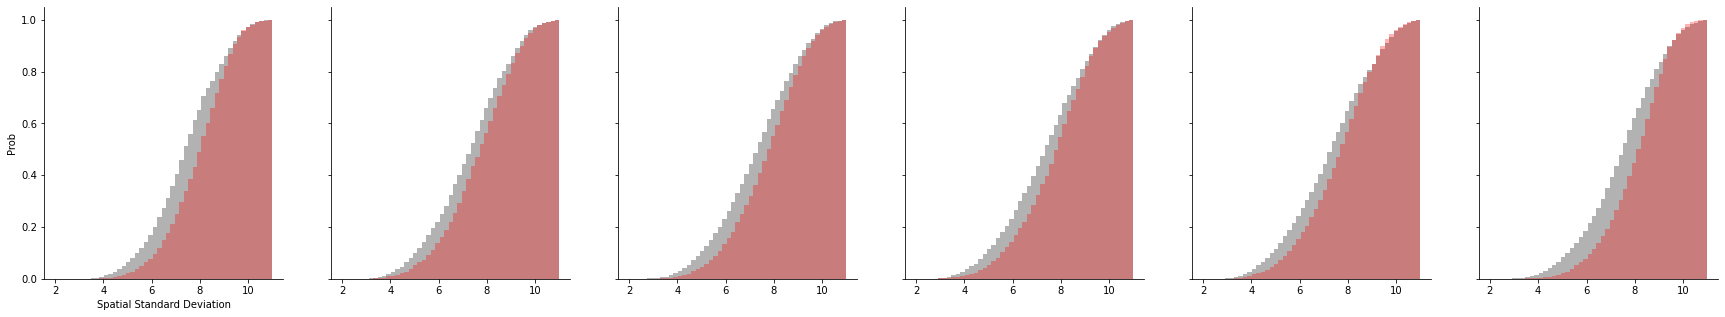

In [16]:
fig,ax = plt.subplots(1,6, figsize = [30,5],sharey=True)
key = 'avg_std'


for day in range(6):
    std = []
    for mouse in ko_mice:
        std.append(np.squeeze(ko_nov_lap_stats[mouse][day][key]))
    std = np.concatenate(std).ravel()  
    print(std.shape)
    bins = np.linspace(2,11,num=50)
    ax[day].hist(std,bins=bins,color='red',density=True, alpha=.3,cumulative=True)

for day in range(6):
    std = []
    for mouse in ctrl_mice:
        std.append(np.squeeze(ctrl_nov_lap_stats[mouse][day][key]))
    std = np.concatenate(std).ravel()  
    print(std.shape)
    bins = np.linspace(2,11,num=50)
    ax[day].hist(std,bins=bins,color='black',density=True, alpha=.3,cumulative=True, zorder= -1)
    ax[day].spines['top'].set_visible(False)
    ax[day].spines['right'].set_visible(False)
    

ax[0].set_ylabel('Prob')
ax[0].set_xlabel('Spatial Standard Deviation')
# fig.savefig(os.path.join(figdir,"avg_std_cum_hist.pdf"))

(5139,)
(5224,)
(5482,)
(5140,)
(4700,)
(4809,)
(5971,)
(4659,)
(4665,)
(5041,)
(4846,)
(4714,)


Text(0.5, 0, 'Number of Peaks')

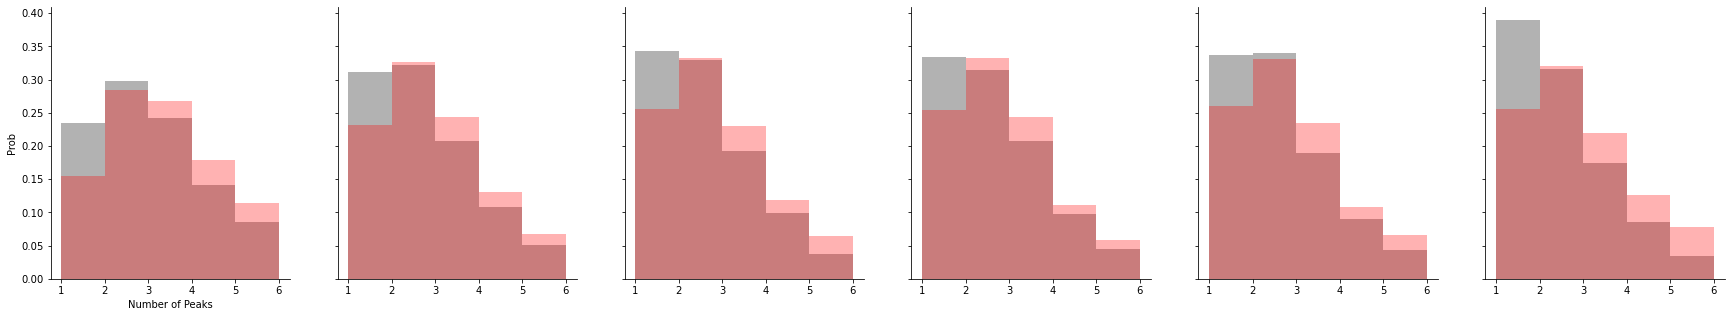

In [17]:
fig,ax = plt.subplots(1,6, figsize = [30,5],sharey=True)
key = 'max_counts'


for day in range(6):
    std = []
    for mouse in ko_mice:
        std.append(np.squeeze(ko_fam_lap_stats[mouse][day][key]))
    std = np.concatenate(std).ravel()  
    print(std.shape)
    bins = np.arange(1,7)
    ax[day].hist(std,bins=bins,color='red',density=True, alpha=.3)

for day in range(6):
    std = []
    for mouse in ctrl_mice:
        std.append(np.squeeze(ctrl_fam_lap_stats[mouse][day][key]))
    std = np.concatenate(std).ravel()  
    print(std.shape)
    bins = np.arange(1,7)
    ax[day].hist(std,bins=bins,color='black',density=True, alpha=.3, zorder= -1)
    ax[day].spines['top'].set_visible(False)
    ax[day].spines['right'].set_visible(False)
    

ax[0].set_ylabel('Prob')
ax[0].set_xlabel('Number of Peaks')
# fig.savefig(os.path.join(figdir,"max_counts_hist.pdf"))

(2384,)
(2278,)
(2566,)
(2149,)
(2008,)
(3082,)
(2338,)
(2308,)
(2376,)
(2597,)
(2530,)
(3158,)


Text(0.5, 0, 'Field Width')

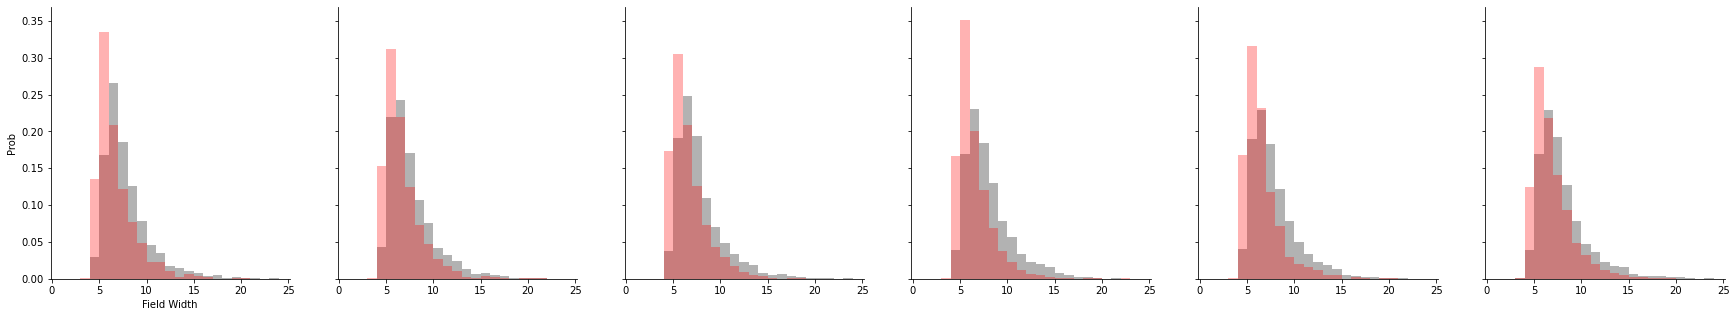

In [133]:
fig,ax = plt.subplots(1,6, figsize = [30,5],sharey=True)
key = 'field_width'


for day in range(6):
    std = []
    for mouse in ko_mice:
        std.append(np.squeeze(ko_nov_lap_stats[mouse][day][key]))
    std = np.concatenate(std).ravel()  
    print(std.shape)
    bins = np.arange(1,25)
    ax[day].hist(std,bins=bins,color='red',density=True, alpha=.3)

for day in range(6):
    std = []
    for mouse in ctrl_mice:
        std.append(np.squeeze(ctrl_nov_lap_stats[mouse][day][key]))
    std = np.concatenate(std).ravel()  
    print(std.shape)
    bins = np.arange(1,25)
    ax[day].hist(std,bins=bins,color='black',density=True, alpha=.3, zorder= -1)
    ax[day].spines['top'].set_visible(False)
    ax[day].spines['right'].set_visible(False)
    

ax[0].set_ylabel('Prob')
ax[0].set_xlabel('Field Width')
# fig.savefig(os.path.join(figdir,"field_width_hist.pdf"))

In [23]:
sess = u.load_single_day(ko_mice[1],day=0)
# sess = u.single_mouse_concat_sessions(ko_mice[0],date_inds = np.arange(0,2))
fam = True
if fam:
    cellmask, _ = place_cell_masks(sess)
    cellmask = np.ones(cellmask.shape)>0
    trialmask = sess.trial_info['LR']==-1*sess.novel_arm

else:
    _,cellmask = place_cell_masks(sess)
    cellmask = np.ones(cellmask.shape)>0
    trialmask = sess.trial_info['LR']==sess.novel_arm
        
        
trial_mat = sess.trial_matrices['spks'][:,:,cellmask]
trial_mat[np.isnan(trial_mat)]=1E-5
trial_mat = trial_mat[trialmask,:,:]
trial_mat_norm = trial_mat/(np.nansum(trial_mat, axis=1,keepdims=True)+1E-5)

avg_trial_mat = trial_mat.mean(axis=0,keepdims=True)

# avg_trial_mat = sp.ndimage.filters.gaussian_filter1d(avg_trial_mat,1,axis=1)
avg_trial_mat_norm = avg_trial_mat/(avg_trial_mat.sum(axis=1,keepdims=True)+1E-5)
avg_trial_mat_z = avg_trial_mat/avg_trial_mat.mean(axis=
                                                   1,keepdims=True)
print(avg_trial_mat_norm.shape)

inds = np.arange(0,trial_mat.shape[1])[np.newaxis, :, np.newaxis]
    
com = (trial_mat_norm*inds).sum(axis=1,keepdims=True)
std = np.power((np.power(inds - com,2)*trial_mat_norm).sum(axis=1,keepdims=True),.5)
print(com.shape, std.shape)

avg_com = (avg_trial_mat_norm*inds).sum(axis=1,keepdims=True)
avg_std = np.power((np.power(inds - avg_com,2)*avg_trial_mat_norm).sum(axis=1,keepdims=True),.5)

skewness = (np.power((inds-avg_com)/avg_std,3)*avg_trial_mat_norm).sum(axis=1)
print(skewness.shape)

{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel': 1, 'ravel_ind': 0}
(1, 30, 332)
(121, 1, 332) (121, 1, 332)
(1, 332)


(array([  1.,   3.,   7.,  22.,  99., 130.,  49.,  15.,   5.,   1.]),
 array([-2.07648064, -1.67601591, -1.27555118, -0.87508644, -0.47462171,
        -0.07415698,  0.32630775,  0.72677249,  1.12723722,  1.52770195,
         1.92816669]),
 <BarContainer object of 10 artists>)

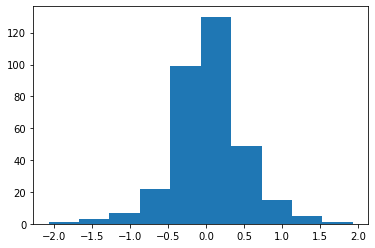

In [24]:
fig,ax = plt.subplots()
ax.hist(skewness.ravel())
# ax.plot(skewness.mean(axis=-1))

[ 9 28]
[18]
[ 5 12]
[24]
[10]
[17 27]
[ 6 11]
[18]
[19]
[16 21 28]
[3]
[12 18 22 26]
[ 4 18 28]
[ 3  9 13 18 22]
[18]
[ 1 21 28]
[ 6 17]
[18 27]
[ 9 14 28]
[ 4 16 19 21 26]
[ 4 12]


<ipython-input-25-7ad473254b39>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,2,sharey=True)


[ 3 20 28]
[10 16]
[20 28]
[ 4 19]
[ 2 11]
[ 7 12 27]
[ 4 28]
[ 7 10 13 28]
[20 28]
[12 17]
[21 28]
[3]
[ 2 17 20]
[ 2  6 13 25 28]
[ 6 27]
[ 4  8 16 23]
[11]
[ 2 18]
[ 2  5 24]
[ 4 17 23]
[ 8 16]
[17]
[13 17]
[6]
[ 8 16 19 28]
[1 7]
[ 9 28]
[ 7  9 11 28]
[ 2 13 20 25 27]


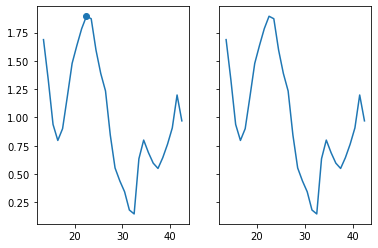

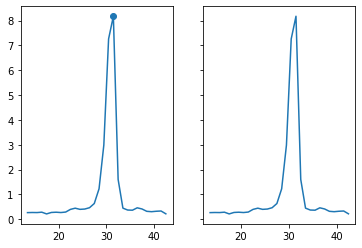

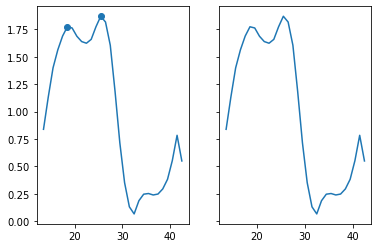

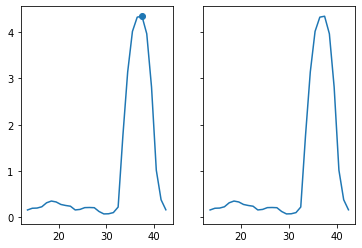

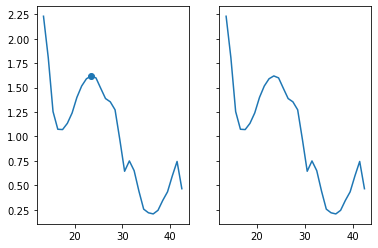

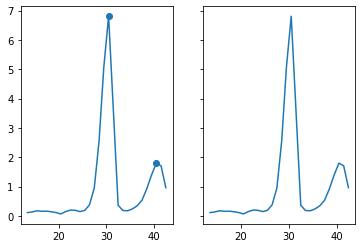

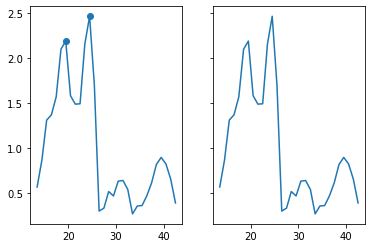

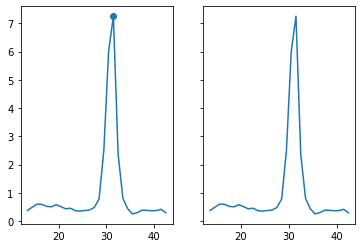

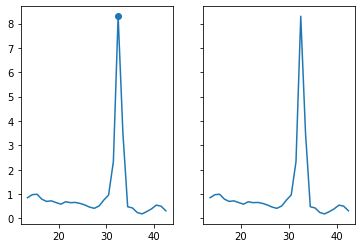

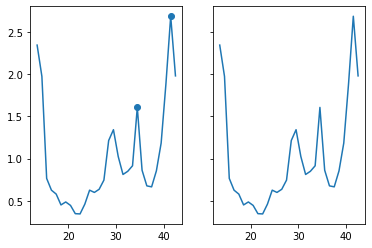

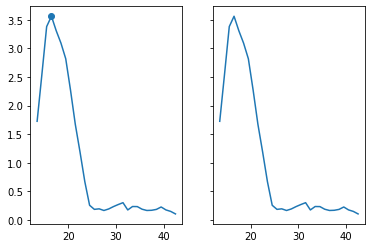

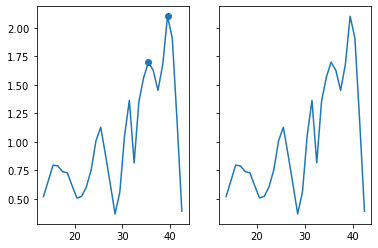

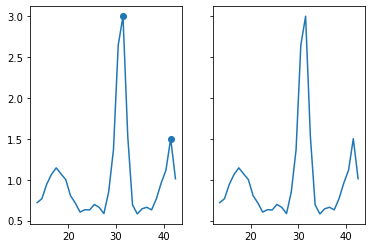

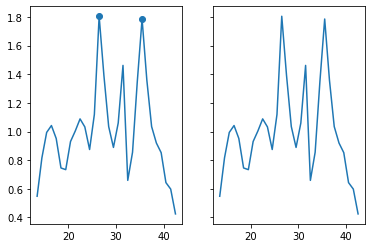

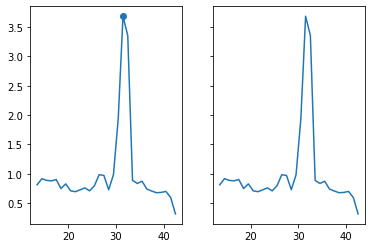

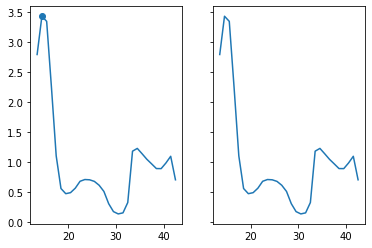

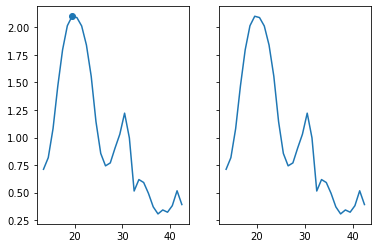

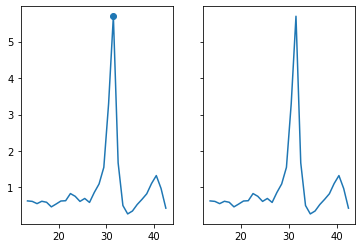

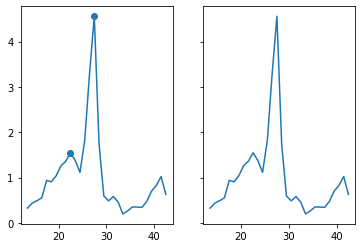

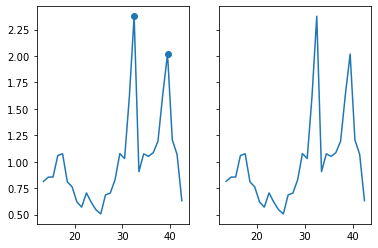

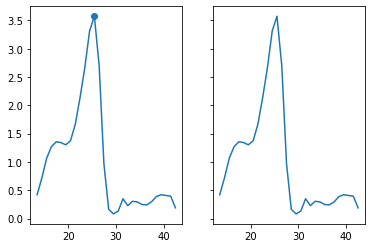

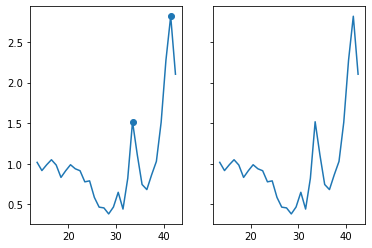

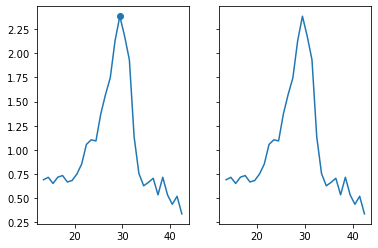

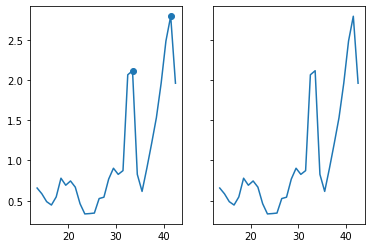

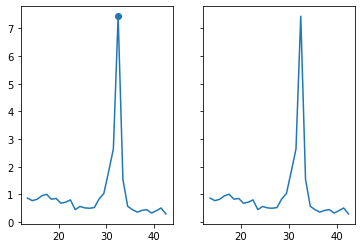

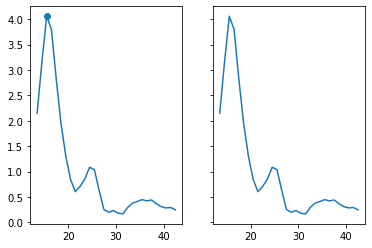

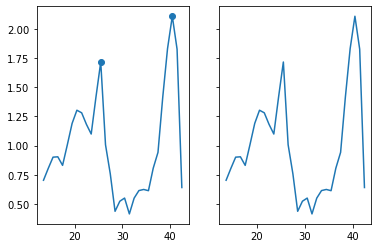

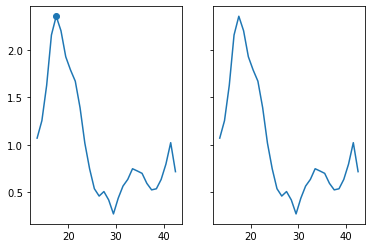

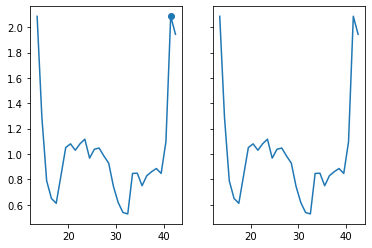

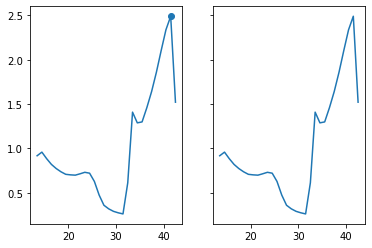

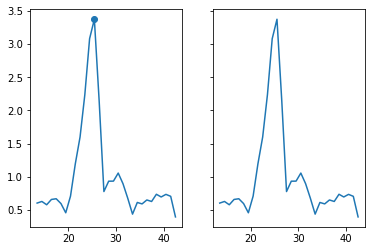

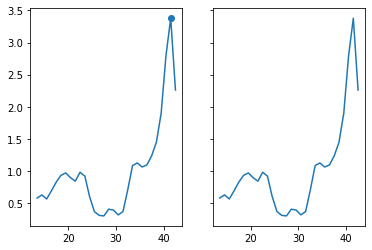

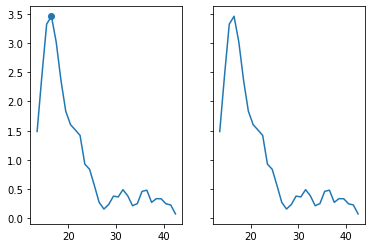

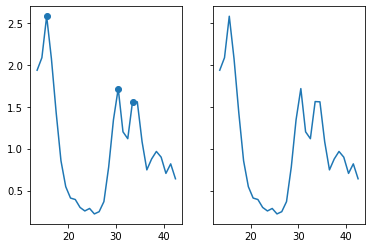

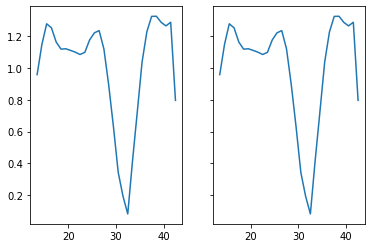

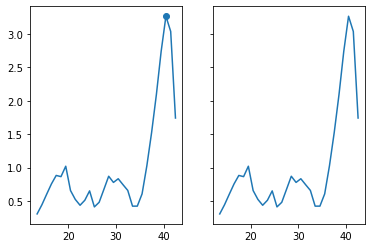

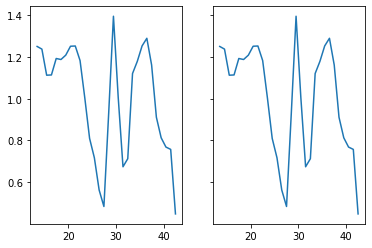

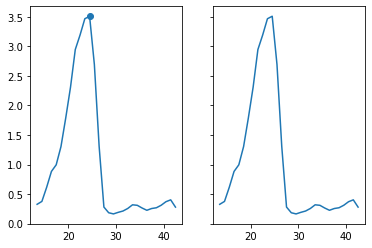

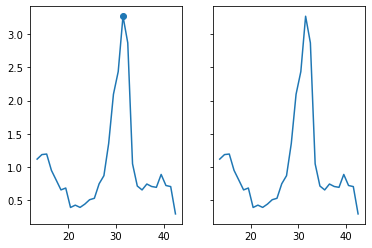

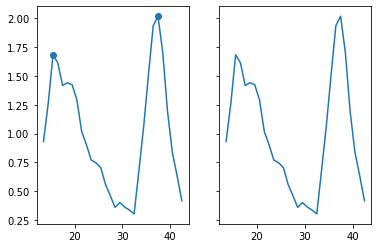

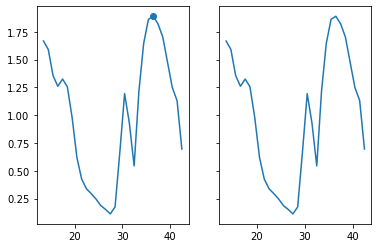

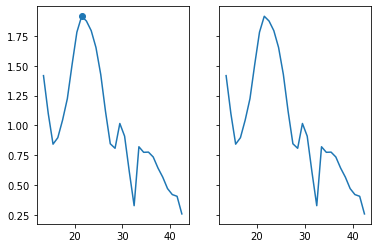

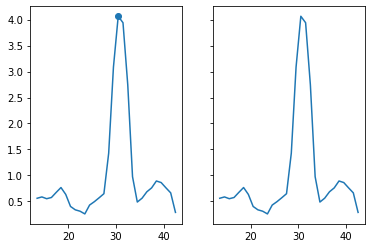

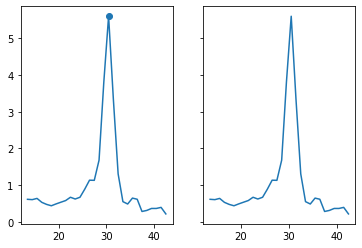

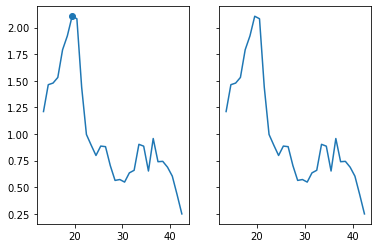

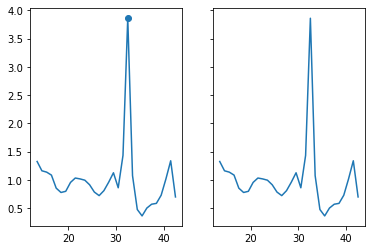

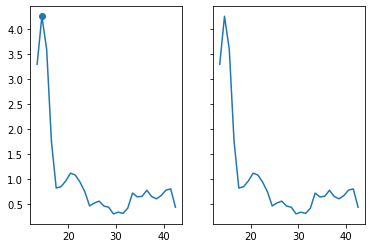

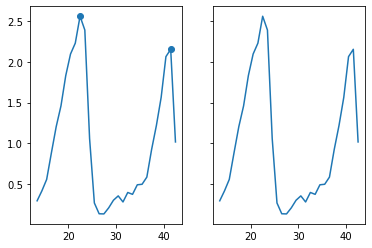

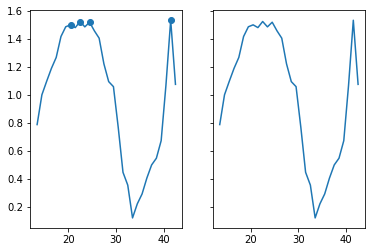

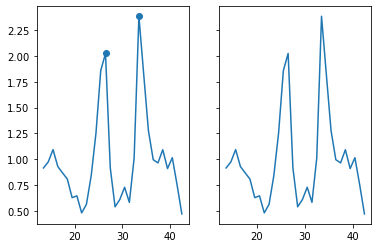

In [25]:
for cell in range(0,50):
    fig, ax = plt.subplots(1,2,sharey=True)
#     ax[0].set_ylim([-2,3])
    mask = avg_trial_mat_norm[0,:,cell]<.0
    print(sp.signal.find_peaks(avg_trial_mat_z[0,:,cell],height=1)[0])
    tmp_mat = np.copy(avg_trial_mat_z[0,:,cell])
    tmp_mat[mask]=.0
    ax[0].plot(sess.trial_matrices['bin_centers'],tmp_mat)
    argmax, _ = sp.signal.find_peaks(tmp_mat,height=1.5)
#     argmax= sp.signal.find_peaks_cwt(tmp_mat,[5,11])
    ax[1].plot(sess.trial_matrices['bin_centers'],avg_trial_mat_z[0,:,cell])
    
    ax[0].scatter(sess.trial_matrices['bin_centers'][argmax],tmp_mat[argmax])
#     ax[0].scatter(sess.trial_matrices['bin_centers'][peak_inds[0,cell]], norm_rate_map[peak_inds[0,cell],cell])
    
#     ax[0].scatter(sess.trial_matrices['bin_centers'][left_edge[cell]], norm_rate_map[left_edge[cell],cell])
#     r_edge = np.minimum(29,right_edge[cell])
#     ax[0].scatter(sess.trial_matrices['bin_centers'][r_edge], norm_rate_map[r_edge,cell])
    
    
#     ax[1].scatter(np.arange(0,trial_mat.shape[0]),oof_rat[:,cell])

NameError: name 'norm_rate_map' is not defined

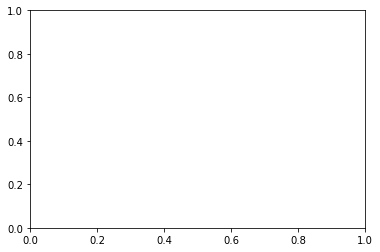

In [147]:
for cell in range(25):
    fig, ax = plt.subplots()
    ax.plot(sess.trial_matrices['bin_centers'],norm_rate_map[:,cell])
    ax.scatter(sess.trial_matrices['bin_centers'][peak_inds[cell]], norm_rate_map[peak_inds[cell],cell])
    
    half_max = norm_rate_map[:,cell]<=.5
    left_mask = half_max*(np.arange(0,norm_rate_map.shape[0])<peak_inds[cell])
    print(left_mask)
    if left_mask.sum()>0:
        left_edge = np.argwhere(left_mask)[-1]
    else:
        left_edge = 0
        
    right_mask = half_max*(np.arange(0,norm_rate_map.shape[0])>peak_inds[cell])
    if right_mask.sum()>0:
        right_edge = np.argwhere(right_mask)[0]
    else:
        right_edge = avg_rate_map.shape[0]-1
    
    ax.scatter(sess.trial_matrices['bin_centers'][left_edge], norm_rate_map[left_edge,cell])
    ax.scatter(sess.trial_matrices['bin_centers'][right_edge], norm_rate_map[right_edge,cell])

In [ ]:
# within-day 


# get familiar arm place cells


# find peak based on average

# define field as FWHM of peak

    # save width
    
# out of field normalized activity rate per trial

# spatial variance of firing rate